In [1]:
# Fuseki IO Development V
## Refinement

# Attach dir one above to handle IDE subdir
import sys, os
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

print(sys.path)
    
import repository
import loader
from rdflib import URIRef, Graph, Namespace

from models.DMEAR import DMEAR_vis 
from visualize_model import visualize, t2rdflibg, get_field

import pandas as pd
import html
import io
import pydotplus
from rdflib.tools.rdf2dot import rdf2dot
from IPython.display import display, Image
import difflib
from urllib.error import HTTPError

from datetime import datetime

start = datetime.now()
import text_utils

['/home/tomk/Documents/Coding/gitHub/datamodels/IDE', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/tomk/environment/devpy/lib/python3.10/site-packages', '/home/tomk/Documents/Coding/gitHub/daglit/src', '/home/tomk/Documents/Coding/gitHub/datamodels/src']
Serialization.Meta [Serialization.SerializationMetaData]
Serialization.Serialization [Serialization.SerializationSpecs]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.TranslationMapping [Serialization.SerializationSpecs]
Serialization.MappingKVPair [Serialization.SerializationSpecs]
Serialization.MetaClass [Serialization.Meta]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.MetaProperty [Serialization.Meta]
Serialization.MetaStaticProperty [Serialization.Meta]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Ser

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.tkltd.org/ontologies/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit:/home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpawlh8lj0
* Owlready2 * HermiT took 0.6324648857116699 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [2]:
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    #print(stream.getvalue())
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g

def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None

In [3]:
store_type="jena"
#store_type="memory"
repo = repository.Repository(store_type=store_type)

In [4]:
# Optional Delete data hosted in master and discourse database graphs
do="No"
#do="No"
do_it_anyway = "No"


if do == "Yes" and store_type != "memory":
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)

    
if do_it_anyway == "Yes":
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)
    

In [5]:
cqr=repo.run_cached_query("get_discourse_details.sparql")
cqr

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash


[{'g': 'http://discourse',
  'discourse': 'http://www.tkltd.org/ontologies/3c800bf3abec4c9c997ab9b4b14f6365',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 1',
  'created': '2023-04-10',
  'hash': 'c812b99e186b-5087-cb18-e9d97172a74f',
  'declarations': 100,
  'entities': 13},
 {'g': 'http://discourse',
  'discourse': 'http://www.tkltd.org/ontologies/e935d1d332c547d38624555d8dbf7906',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 2',
  'created': '2023-04-11',
  'hash': '5eac137edc61-a146-cbe1-78936bdcc7ab',
  'declarations': 191,
  'entities': 24},
 {'g': 'http://discourse',
  'discourse': 'http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 3',
  'created': '2023-04-12',
  'hash': '2b2ddfe26295-998b-24d7-5d03c532a137',
  'declarations': 449,

In [6]:
if do == "Yes":
    repo.truncate_graph(repo.registered_serializations_uri)
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)
    repo.truncate_graph(repo.ontology_graph_uri)


In [7]:

repo.register_serialization("../src/models/sample/sample_ser.rdf")
repo.register_serialization("../src/models/DMEAR/DMEAR_ser.rdf")

In [8]:
g = Graph()
g.parse("../src/models/DMEAR/DMEAR_ser.rdf")

<Graph identifier=Ne2d377c293844e2a96e67bd2b0645917 (<class 'rdflib.graph.Graph'>)>

In [9]:
rs = g.query("""PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX ser: <http://www.tkltd.org/ontologies/serialization#> 
select ?s ?p ?o
WHERE { ?s ?p ?o. 
VALUES ?p { ser:MappingDomain ser:MappingRange ser:SerializationLabel ser:SerializationParentLabel}}""")

ser_label_set = set([o.toPython() for s,p,o in rs])
ser_label_set

{'Attribute',
 'AttributeDescription',
 'Class',
 'ClassDescription',
 'Context',
 'ContextDescription',
 'DataType',
 'Domain',
 'DomainDescription',
 'FromAttribute',
 'FromCardinality',
 'FromClass',
 'IsPK',
 'Model',
 'ModelDescription',
 'ModelType',
 'Nulls',
 'Relationship',
 'SubContext',
 'ToAttribute',
 'ToCardinality',
 'ToClass'}

In [10]:
rs = repo.ds.query("""PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX ser: <http://www.tkltd.org/ontologies/serialization#> 
select ?s ?p ?o
WHERE { GRAPH <http://config> { ?m ?p ?o. 
?m ser:IsComponentOfSerialization ?s. 
VALUES ?p { ser:MappingDomain ser:MappingRange ser:SerializationLabel ser:SerializationParentLabel}}}""")

ser_label_set = set([(s.toPython(), o.toPython()) for s,p,o in rs])
ser_label_d = dict()
for s,o in ser_label_set:
    if s in ser_label_d.keys():
        ser_label_d[s].add(o)
    else:
        ser_label_d[s]=set([o])

ser_label_d

{'http://www.tkltd.org/serializations/DMEAR': {'Attribute',
  'AttributeDescription',
  'Class',
  'ClassDescription',
  'Context',
  'ContextDescription',
  'DataType',
  'Domain',
  'DomainDescription',
  'FromAttribute',
  'FromCardinality',
  'FromClass',
  'IsPK',
  'Model',
  'ModelDescription',
  'ModelType',
  'Nulls',
  'Relationship',
  'SubContext',
  'ToAttribute',
  'ToCardinality',
  'ToClass'},
 'http://www.tkltd.org/serializations/Sample_Serialisation': {'Class',
  'DataProperty',
  'ParentClass',
  'Property',
  'SubClassPointer'}}

In [11]:
qqr = repo.ds.query("""
select ?g ?s ?p ?o
WHERE { GRAPH ?g { 
?s ?p ?o .
FILTER (?o=<http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#Serialization>) }}""")

In [12]:
pd.DataFrame(qqr).values#.iloc[1].values

array([], shape=(0, 0), dtype=float64)

In [13]:
file_dtypes = {'Domain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'IsPK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}


In [14]:
ser_label_set

{('http://www.tkltd.org/serializations/DMEAR', 'Attribute'),
 ('http://www.tkltd.org/serializations/DMEAR', 'AttributeDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Class'),
 ('http://www.tkltd.org/serializations/DMEAR', 'ClassDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Context'),
 ('http://www.tkltd.org/serializations/DMEAR', 'ContextDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'DataType'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Domain'),
 ('http://www.tkltd.org/serializations/DMEAR', 'DomainDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'FromAttribute'),
 ('http://www.tkltd.org/serializations/DMEAR', 'FromCardinality'),
 ('http://www.tkltd.org/serializations/DMEAR', 'FromClass'),
 ('http://www.tkltd.org/serializations/DMEAR', 'IsPK'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Model'),
 ('http://www.tkltd.org/serializations/DMEAR', 'ModelDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Mode

In [15]:
mpd = {"created" : "2023-04-10", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 1", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-10"}

metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"../sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
col_set = set(repository.get_variables_from_flat_query_results( datarows))

In [16]:
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
match_ser

'http://www.tkltd.org/serializations/DMEAR'

In [17]:
assert False

AssertionError: 

In [18]:
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.023238 for 100 from 9
//////LOCATE2/////
self.members: 100
This data is already loaded! - Aborting


In [ ]:
datarows

In [ ]:
qr = repo.run_cached_query("get_discourse_details.sparql")
qr_df = pd.DataFrame(qr)
qr_df

In [19]:
mpd = {"created" : "2023-04-11", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 2", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-11"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.034456 for 191 from 18
//////LOCATE2/////
self.members: 191
This data is already loaded! - Aborting


In [20]:
mpd = {"created" : "2023-04-12", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 3", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-12"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v3.0"
model_data = pd.read_csv(r"../sample/inventory_v3.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.072065 for 449 from 44
//////LOCATE2/////
self.members: 449
This data is already loaded! - Aborting


In [21]:
mpd = {"created" : "2023-04-13", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 4", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-13"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v4.0"
model_data = pd.read_csv(r"../sample/inventory_v4.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.075933 for 478 from 47
//////LOCATE2/////
self.members: 478
This data is already loaded! - Aborting


In [22]:
repo.discourse_hashes

[('c812b99e186b-5087-cb18-e9d97172a74f',
  'http://www.tkltd.org/ontologies/3c800bf3abec4c9c997ab9b4b14f6365'),
 ('5eac137edc61-a146-cbe1-78936bdcc7ab',
  'http://www.tkltd.org/ontologies/e935d1d332c547d38624555d8dbf7906'),
 ('2b2ddfe26295-998b-24d7-5d03c532a137',
  'http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2'),
 ('753a282dd62e-89d4-5bbb-a4f78df8f22b',
  'http://www.tkltd.org/ontologies/48bcc910ff2641f38b73ff44cd634479')]

In [24]:
qr = repo.run_cached_query("get_discourse_details.sparql")
qr_df = pd.DataFrame(qr)
qr_df

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash


g                                          discourse  \
0  http://discourse  http://www.tkltd.org/ontologies/3c800bf3abec4c...   
1  http://discourse  http://www.tkltd.org/ontologies/e935d1d332c547...   
2  http://discourse  http://www.tkltd.org/ontologies/4271dd88362240...   
3  http://discourse  http://www.tkltd.org/ontologies/48bcc910ff2641...   

                      name          title                 description  \
0  discourse_inventory ERD  inventory ERD  Sample ERD model version 1   
1  discourse_inventory ERD  inventory ERD  Sample ERD model version 2   
2  discourse_inventory ERD  inventory ERD  Sample ERD model version 3   
3  discourse_inventory ERD  inventory ERD  Sample ERD model version 4   

      created                                 hash  declarations  entities  
0  2023-04-10  c812b99e186b-5087-cb18-e9d97172a74f           100        13  
1  2023-04-11  5eac137edc61-a146-cbe1-78936bdcc7ab           191        24  
2  2023-04-12  2b2ddfe26295-998b-24d7-5d03c532a137           449        56  
3  2023-04-13  753a282dd62e-89d4-5bbb-a4f78df8f22b           478        59

In [25]:
qr

[{'g': 'http://discourse',
  'discourse': 'http://www.tkltd.org/ontologies/3c800bf3abec4c9c997ab9b4b14f6365',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 1',
  'created': '2023-04-10',
  'hash': 'c812b99e186b-5087-cb18-e9d97172a74f',
  'declarations': 100,
  'entities': 13},
 {'g': 'http://discourse',
  'discourse': 'http://www.tkltd.org/ontologies/e935d1d332c547d38624555d8dbf7906',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 2',
  'created': '2023-04-11',
  'hash': '5eac137edc61-a146-cbe1-78936bdcc7ab',
  'declarations': 191,
  'entities': 24},
 {'g': 'http://discourse',
  'discourse': 'http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 3',
  'created': '2023-04-12',
  'hash': '2b2ddfe26295-998b-24d7-5d03c532a137',
  'declarations': 449,

In [26]:
qi = qr_df.query("description in ['Sample ERD model version 3', 'Sample ERD model version 4'] ").index.values
qi

array([2, 3])

In [27]:
dict(qr_df.iloc[3])

{'g': 'http://discourse',
 'discourse': 'http://www.tkltd.org/ontologies/48bcc910ff2641f38b73ff44cd634479',
 'name': 'discourse_inventory ERD',
 'title': 'inventory ERD',
 'description': 'Sample ERD model version 4',
 'created': '2023-04-13',
 'hash': '753a282dd62e-89d4-5bbb-a4f78df8f22b',
 'declarations': 478,
 'entities': 59}

In [28]:
d1 = qr_df.iloc[qi[0]]['discourse']
d2 = qr_df.iloc[qi[1]]['discourse']
#get_posits_sparql = sparql.replace("%%p1%%", ",".join([d1,d2]))

d1,d2

('http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2',
 'http://www.tkltd.org/ontologies/48bcc910ff2641f38b73ff44cd634479')

In [29]:

qr = repo.run_cached_query("get_discourse_posits_parms_discourse_iris.sparql", parameters=[",".join([URIRef(d1).n3(),URIRef(d2).n3()])], native_rdflib=True)
#results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(qr)
#set(dcontents['p'])
dcontents

('%%p0%%', '<http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2>,<http://www.tkltd.org/ontologies/48bcc910ff2641f38b73ff44cd634479>')
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refutation disco:Predicate ?p.
                   ?refutation d

g                                          discourse  \
0    http://discourse  http://www.tkltd.org/ontologies/4271dd88362240...   
1    http://discourse  http://www.tkltd.org/ontologies/4271dd88362240...   
2    http://discourse  http://www.tkltd.org/ontologies/4271dd88362240...   
3    http://discourse  http://www.tkltd.org/ontologies/4271dd88362240...   
4    http://discourse  http://www.tkltd.org/ontologies/4271dd88362240...   
..                ...                                                ...   
922  http://discourse  http://www.tkltd.org/ontologies/48bcc910ff2641...   
923  http://discourse  http://www.tkltd.org/ontologies/48bcc910ff2641...   
924  http://discourse  http://www.tkltd.org/ontologies/48bcc910ff2641...   
925  http://discourse  http://www.tkltd.org/ontologies/48bcc910ff2641...   
926  http://discourse  http://www.tkltd.org/ontologies/48bcc910ff2641...   

                                             assertion refutation posit  \
0    http://www.tkltd.org/ontologies/0be131c2cfdf-c...       None  None   
1    http://www.tkltd.org/ontologies/fc1449077b56-0...       None  None   
2    http://www.tkltd.org/ontologies/23e2d98a9c0e-d...       None  None   
3    http://www.tkltd.org/ontologies/2108ace382a1-d...       None  None   
4    http://www.tkltd.org/ontologies/90935ccd94e2-7...       None  None   
..                                                 ...        ...   ...   
922  http://www.tkltd.org/ontologies/16911439fef6-8...       None  None   
923  http://www.tkltd.org/ontologies/1d7060732402-b...       None  None   
924  http://www.tkltd.org/ontologies/2cb2bad5a541-0...       None  None   
925  http://www.tkltd.org/ontologies/4b35eeb539fc-5...       None  None   
926  http://www.tkltd.org/ontologies/ab283421f46b-f...       None  None   

                                                     s  \
0    http://www.tkltd.org/ontologies/c0d06df249eb4a...   
1    http://www.tkltd.org/ontologies/6d300a8c447041...   
2    http://www.tkltd.org/ontologies/7c02b04111fc47...   
3    http://www.tkltd.org/ontologies/4373155e238248...   
4    http://www.tkltd.org/ontologies/9cd8bf9bdc104d...   
..                                                 ...   
922  http://www.tkltd.org/ontologies/de4dc9ac6cc945...   
923  http://www.tkltd.org/ontologies/e5e6eb8a5cf849...   
924  http://www.tkltd.org/ontologies/19ccd5a0f4d04e...   
925  http://www.tkltd.org/ontologies/8735c6a9aac64b...   
926  http://www.tkltd.org/ontologies/00f295f0825f4d...   

                                                     p  \
0           http://www.w3.org/2000/01/rdf-schema#label   
1           http://www.w3.org/2000/01/rdf-schema#label   
2    http://www.tkltd.org/ontologies/datamodel#Clas...   
3    http://www.tkltd.org/ontologies/datamodel#isId...   
4      http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
..                                                 ...   
922  http://www.tkltd.org/ontologies/serialization#...   
923    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
924  http://www.tkltd.org/ontologies/datamodel#Rela...   
925  http://www.tkltd.org/ontologies/serialization#...   
926  http://www.tkltd.org/ontologies/datamodel#Clas...   

                                                     o  
0                                    Staff --&gt; Role  
1                             Inventory --&gt; Product  
2    http://www.tkltd.org/ontologies/36460dd9a3c141...  
3                                                   No  
4    http://www.tkltd.org/ontologies/datamodel#Attr...  
..                                                 ...  
922  _.Simple ERD Model - Inventory.Customer.custom...  
923  http://www.tkltd.org/ontologies/datamodel#Attr...  
924  http://www.tkltd.org/ontologies/2308d16ed6924d...  
925  _.Simple ERD Model - Inventory.Product.descrip...  
926  http://www.tkltd.org/ontologies/9cd8bf9bdc104d...  

[927 rows x 8 columns]

In [30]:
dcontents['o'].values

array([rdflib.term.Literal('Staff --&gt; Role'),
       rdflib.term.Literal('Inventory --&gt; Product'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/36460dd9a3c14188a9c55950f8765a27'),
       rdflib.term.Literal('No'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/datamodel#Attribute'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/0f93db94db47446f8cbb4e29cd67177a'),
       rdflib.term.Literal('_.Simple ERD Model - Inventory.OrderItem.qorder_id'),
       rdflib.term.Literal('_.Simple ERD Model - Inventory.OrderItem.total_price'),
       rdflib.term.Literal('Date used for calculating base prices.'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/7c02b04111fc4722866f6932bf30ea99'),
       rdflib.term.Literal('Unique Identifier for this qoute/order.'),
       rdflib.term.Literal('customer_postal_code'),
       rdflib.term.Literal('No'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/datamodel#Class'),
       rdflib.term.Lite

In [31]:

dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()

In [32]:
d1, d2

('http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2',
 'http://www.tkltd.org/ontologies/48bcc910ff2641f38b73ff44cd634479')

In [33]:
from rdflib.util import from_n3
URIRef(d1)

rdflib.term.URIRef('http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2')

In [34]:
dcd.keys()

dict_keys([rdflib.term.URIRef('http://www.tkltd.org/ontologies/4271dd8836224092b1f8d8de8403d2f2'), rdflib.term.URIRef('http://www.tkltd.org/ontologies/48bcc910ff2641f38b73ff44cd634479')])

In [35]:
dcd.get(d1)

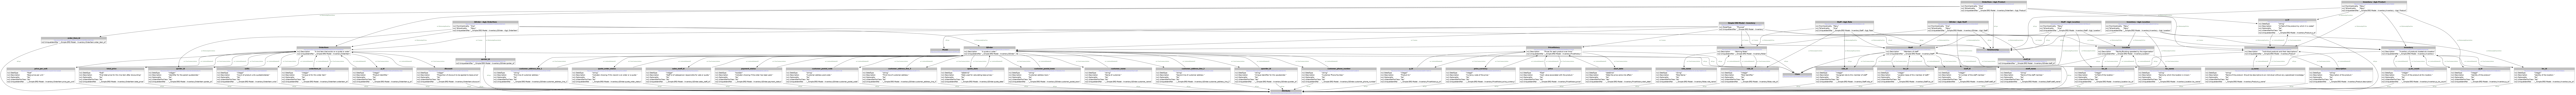

In [36]:
s1 = dcd.get(URIRef(d1))
s2 = dcd.get(URIRef(d2))
visualize(t2rdflibg(s1))

In [37]:
option_dict = { "u_label" : True, 
                "label" : True, 
                "desc" : True, 
                "optionality" : True, 
                "pk" : True, 
                "datatype" : True }

option_dict["optionality"]!=False

True

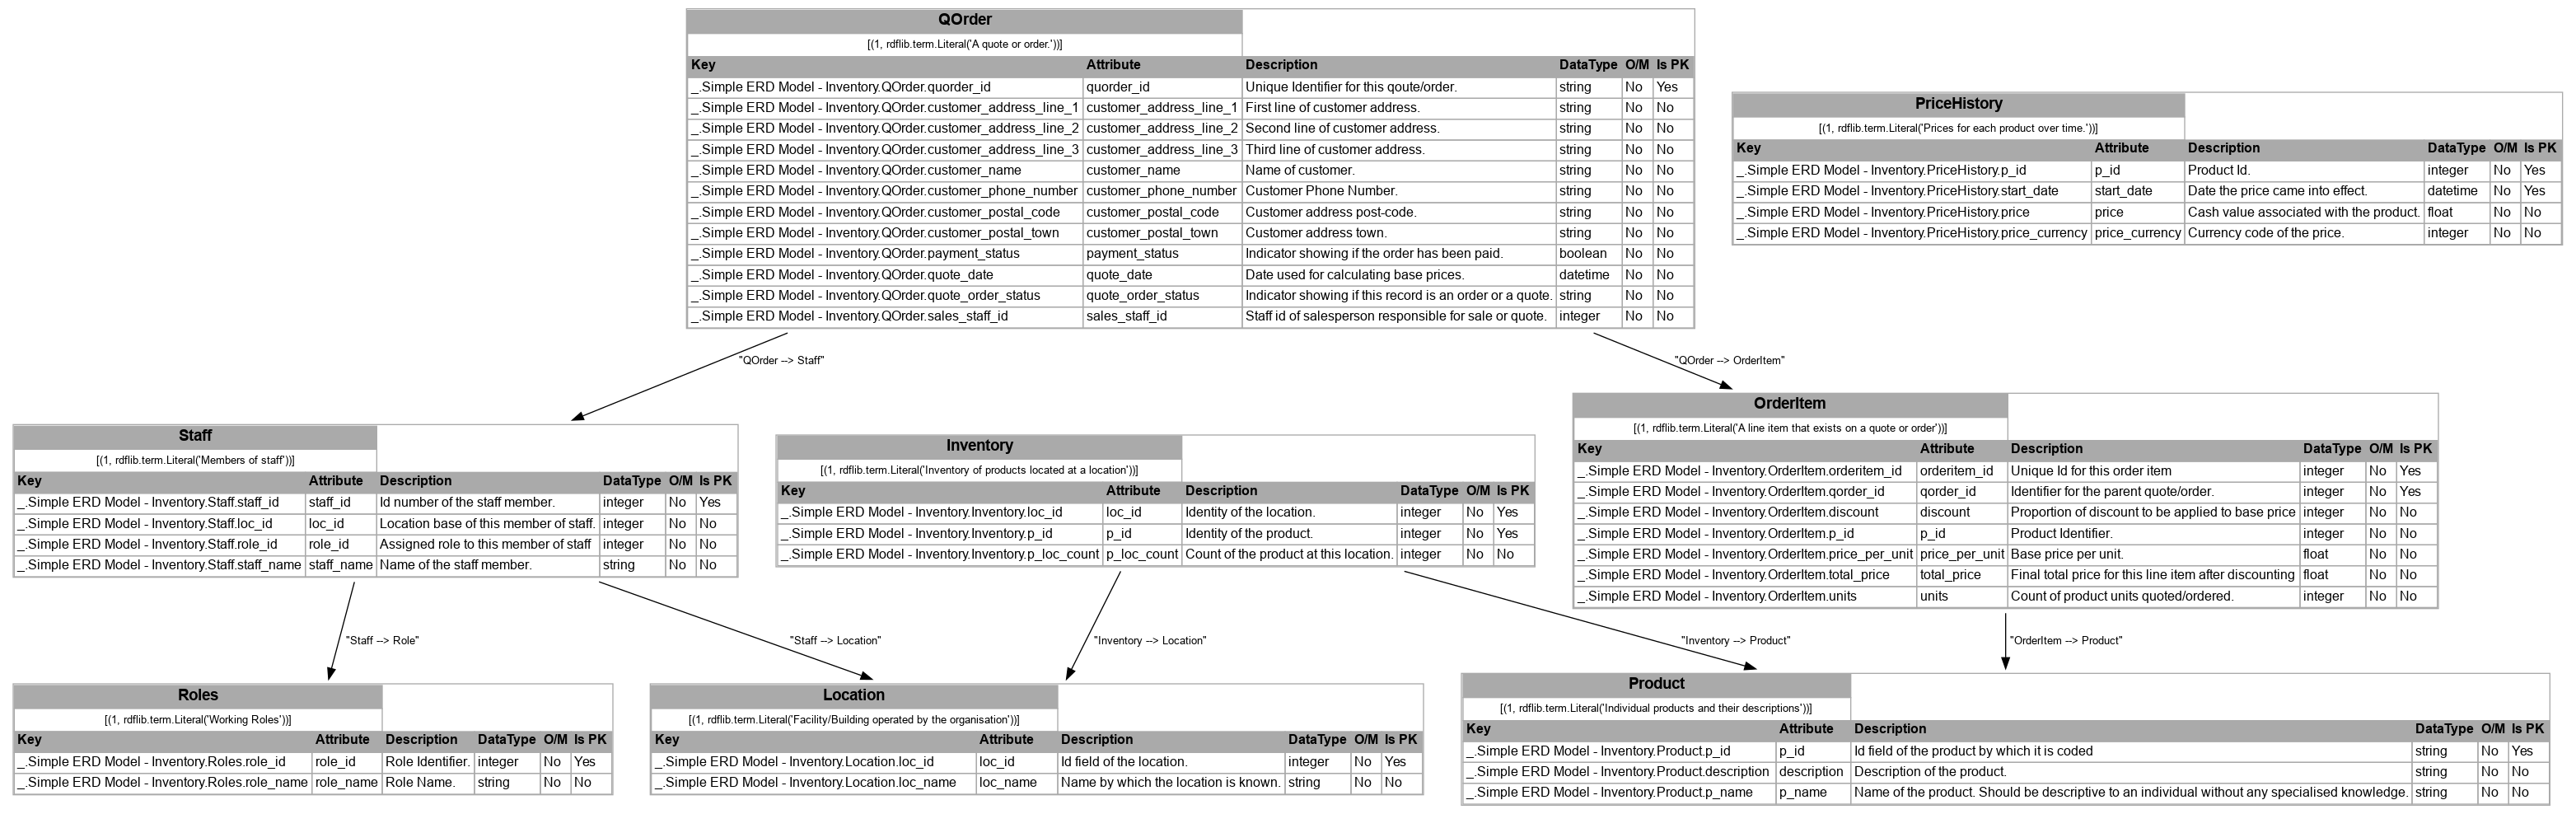

In [38]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, engine="dot", v_type="png")))

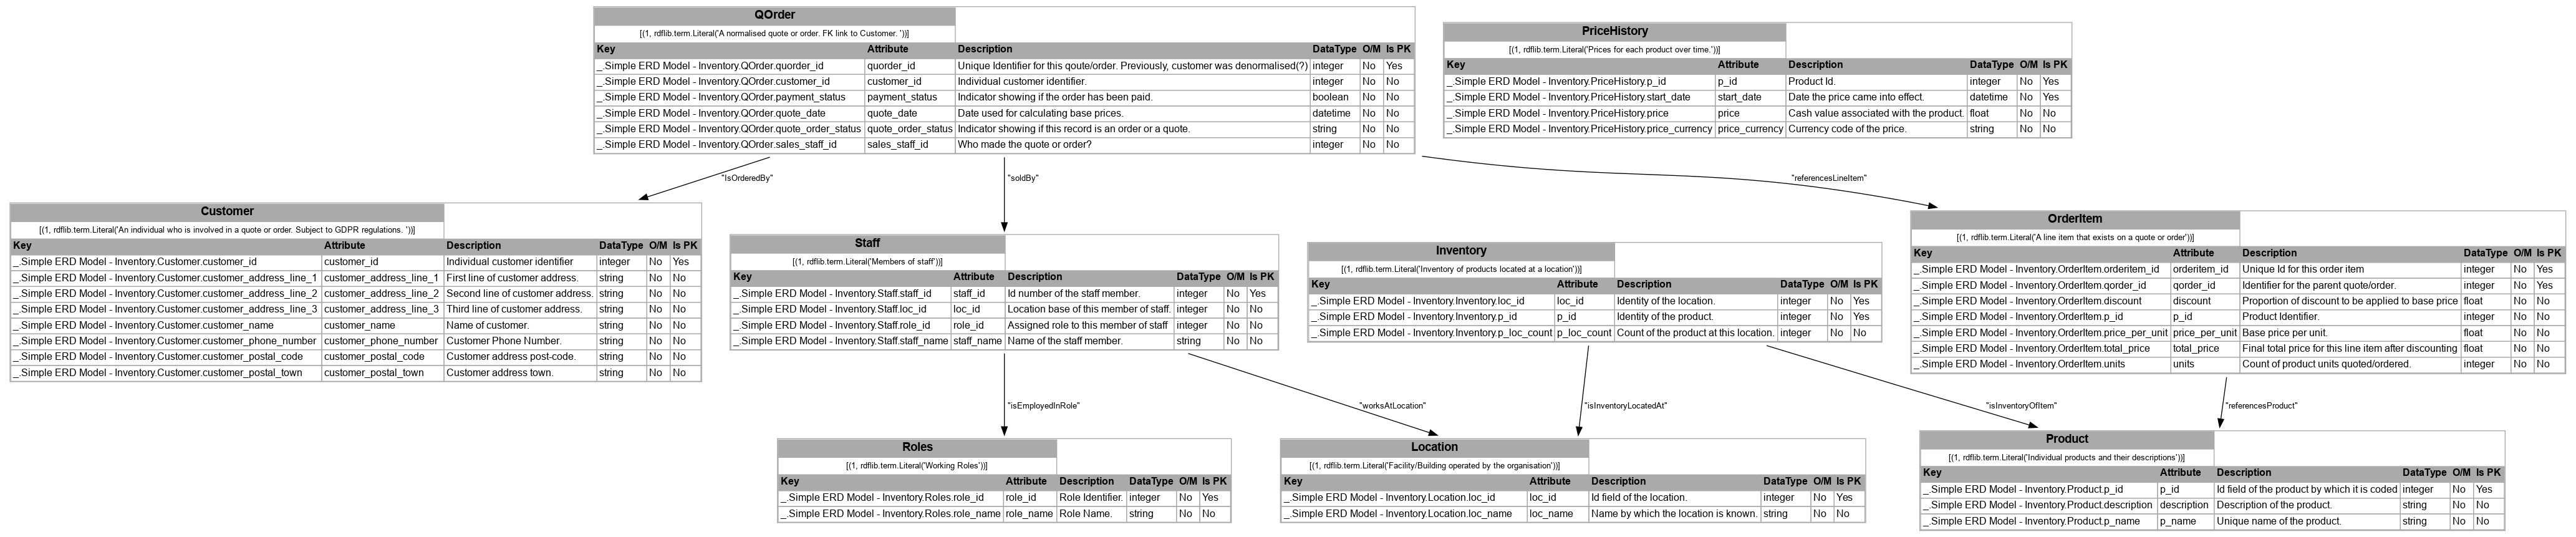

In [39]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s2, option_dict, engine="dot", v_type="png")))

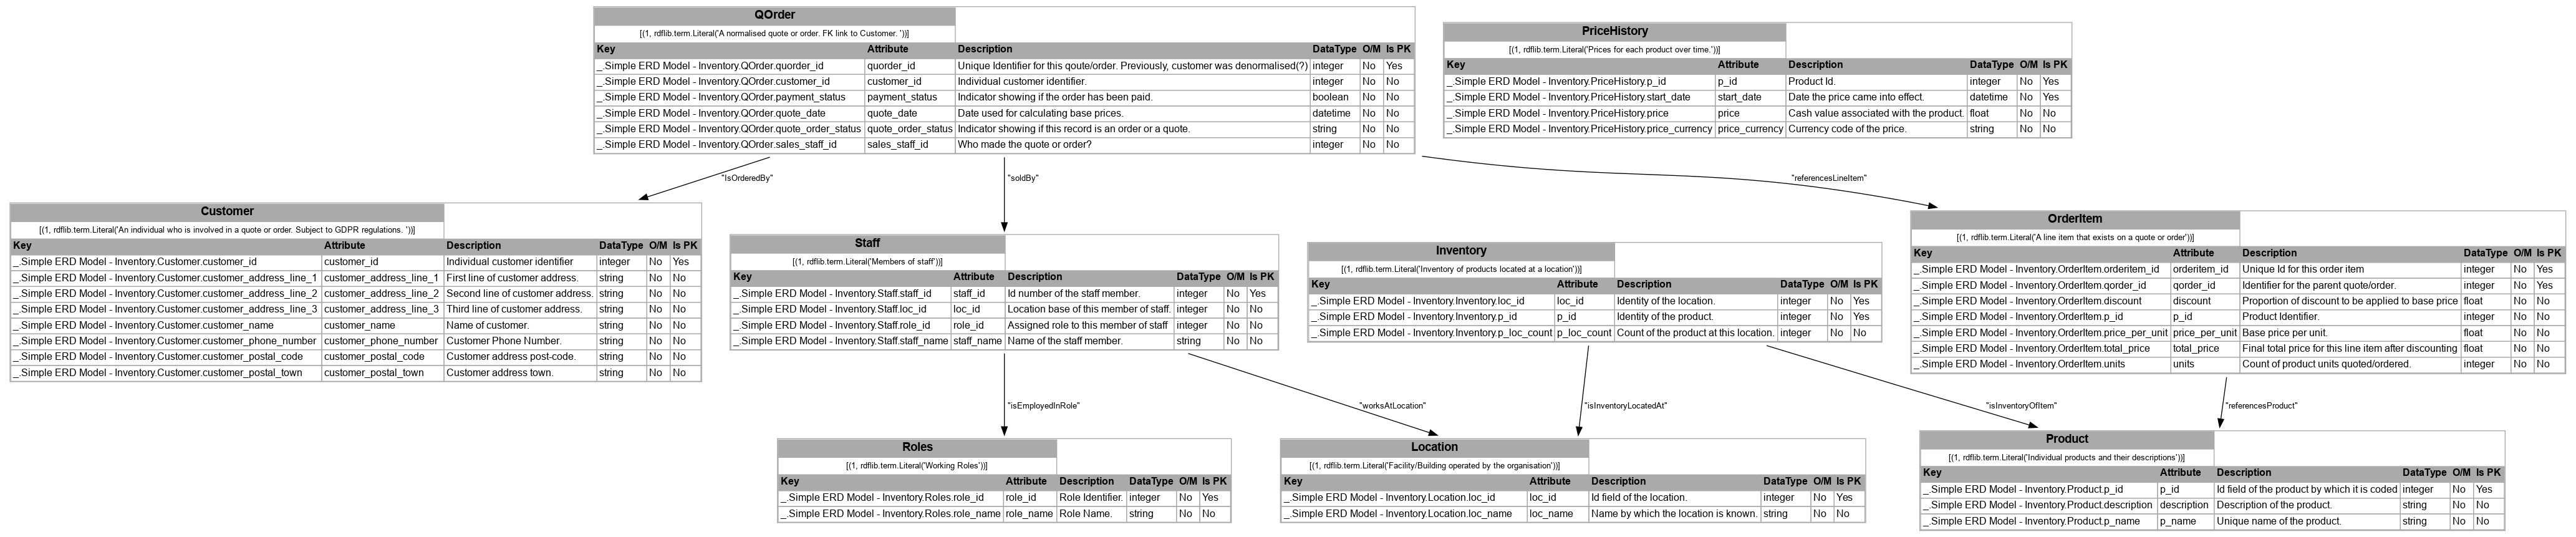

In [40]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s2, option_dict, v_type="png")))

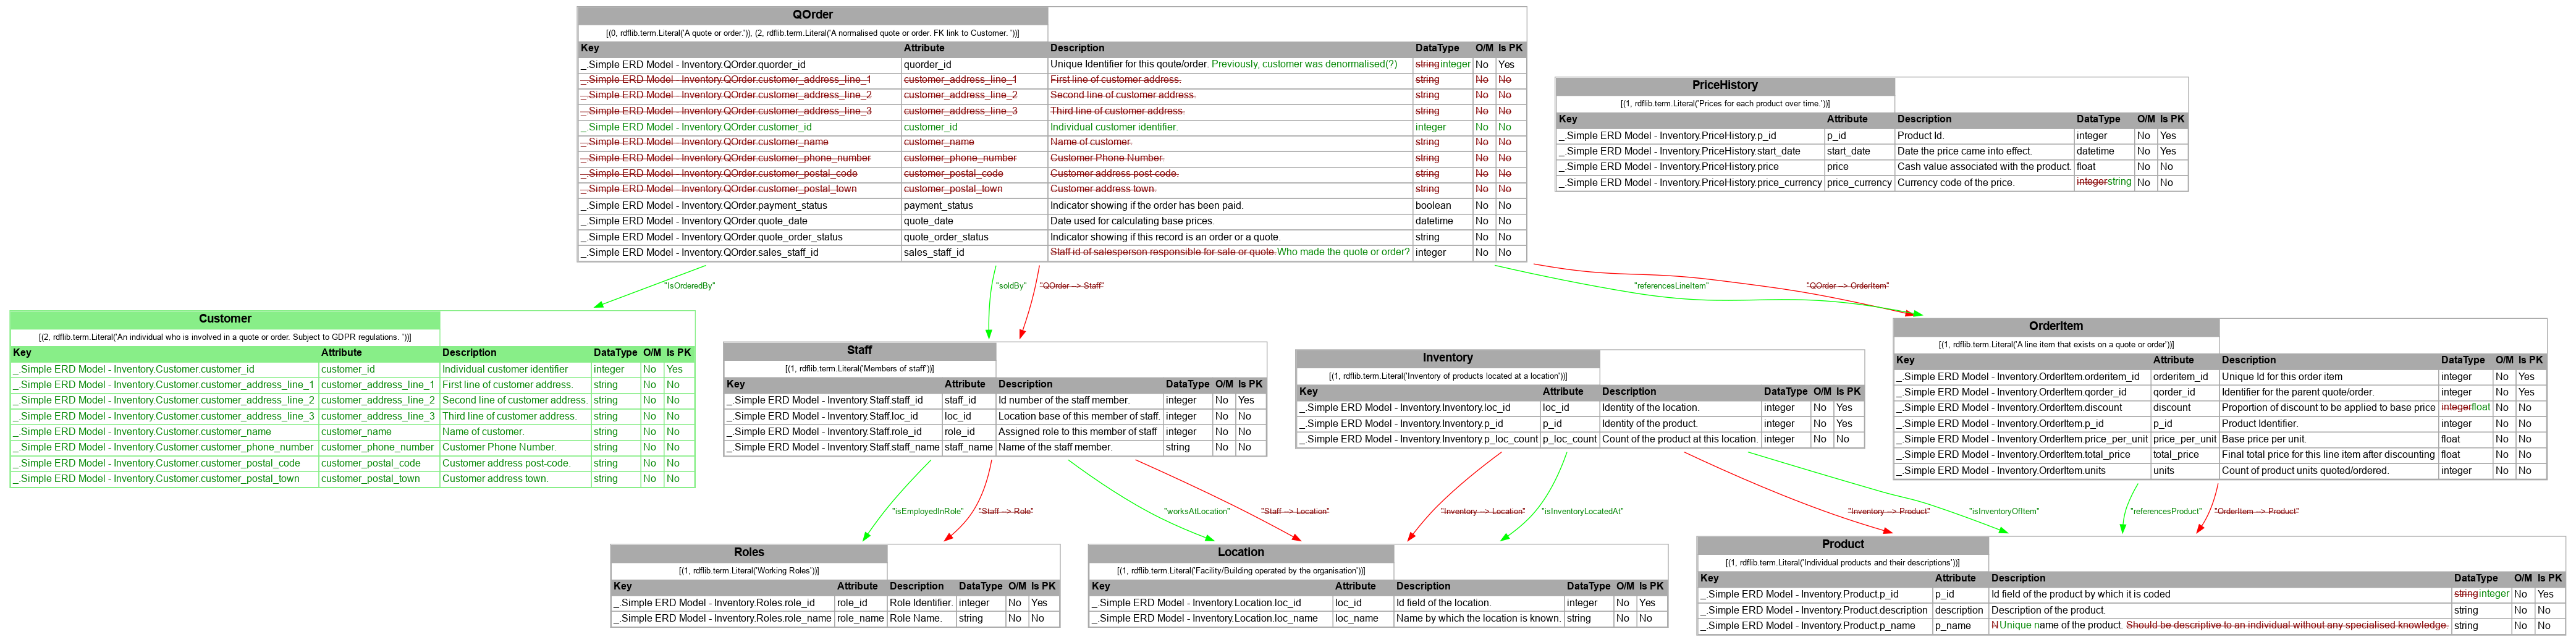

In [41]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s2, option_dict, v_type="png")))

In [44]:
option_dict = { "u_label" : False, 
                "label" : True, 
                "desc" : True, 
                "optionality" : True, 
                "pk" : True, 
                "datatype" : True }

option_dict["optionality"]!=False

True

In [46]:
s1

{(rdflib.term.URIRef('http://www.tkltd.org/ontologies/00f295f0825f4d01b38735160a082daa'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/datamodel#ClassContainsAttribute'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/245b513e21734e62b45c94c7ab43a623')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/00f295f0825f4d01b38735160a082daa'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/datamodel#ClassContainsAttribute'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/2cd736b8667548b3a0f20d929e2c3bdc')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/00f295f0825f4d01b38735160a082daa'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/datamodel#ClassContainsAttribute'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/8308070d93124bd18b3464485afda37c')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/00f295f0825f4d01b38735160a082daa'),
  rdflib.term.URIRef('http://www.tkltd.org/ontologies/datamodel#ClassContainsAttribute'),
  rdfli

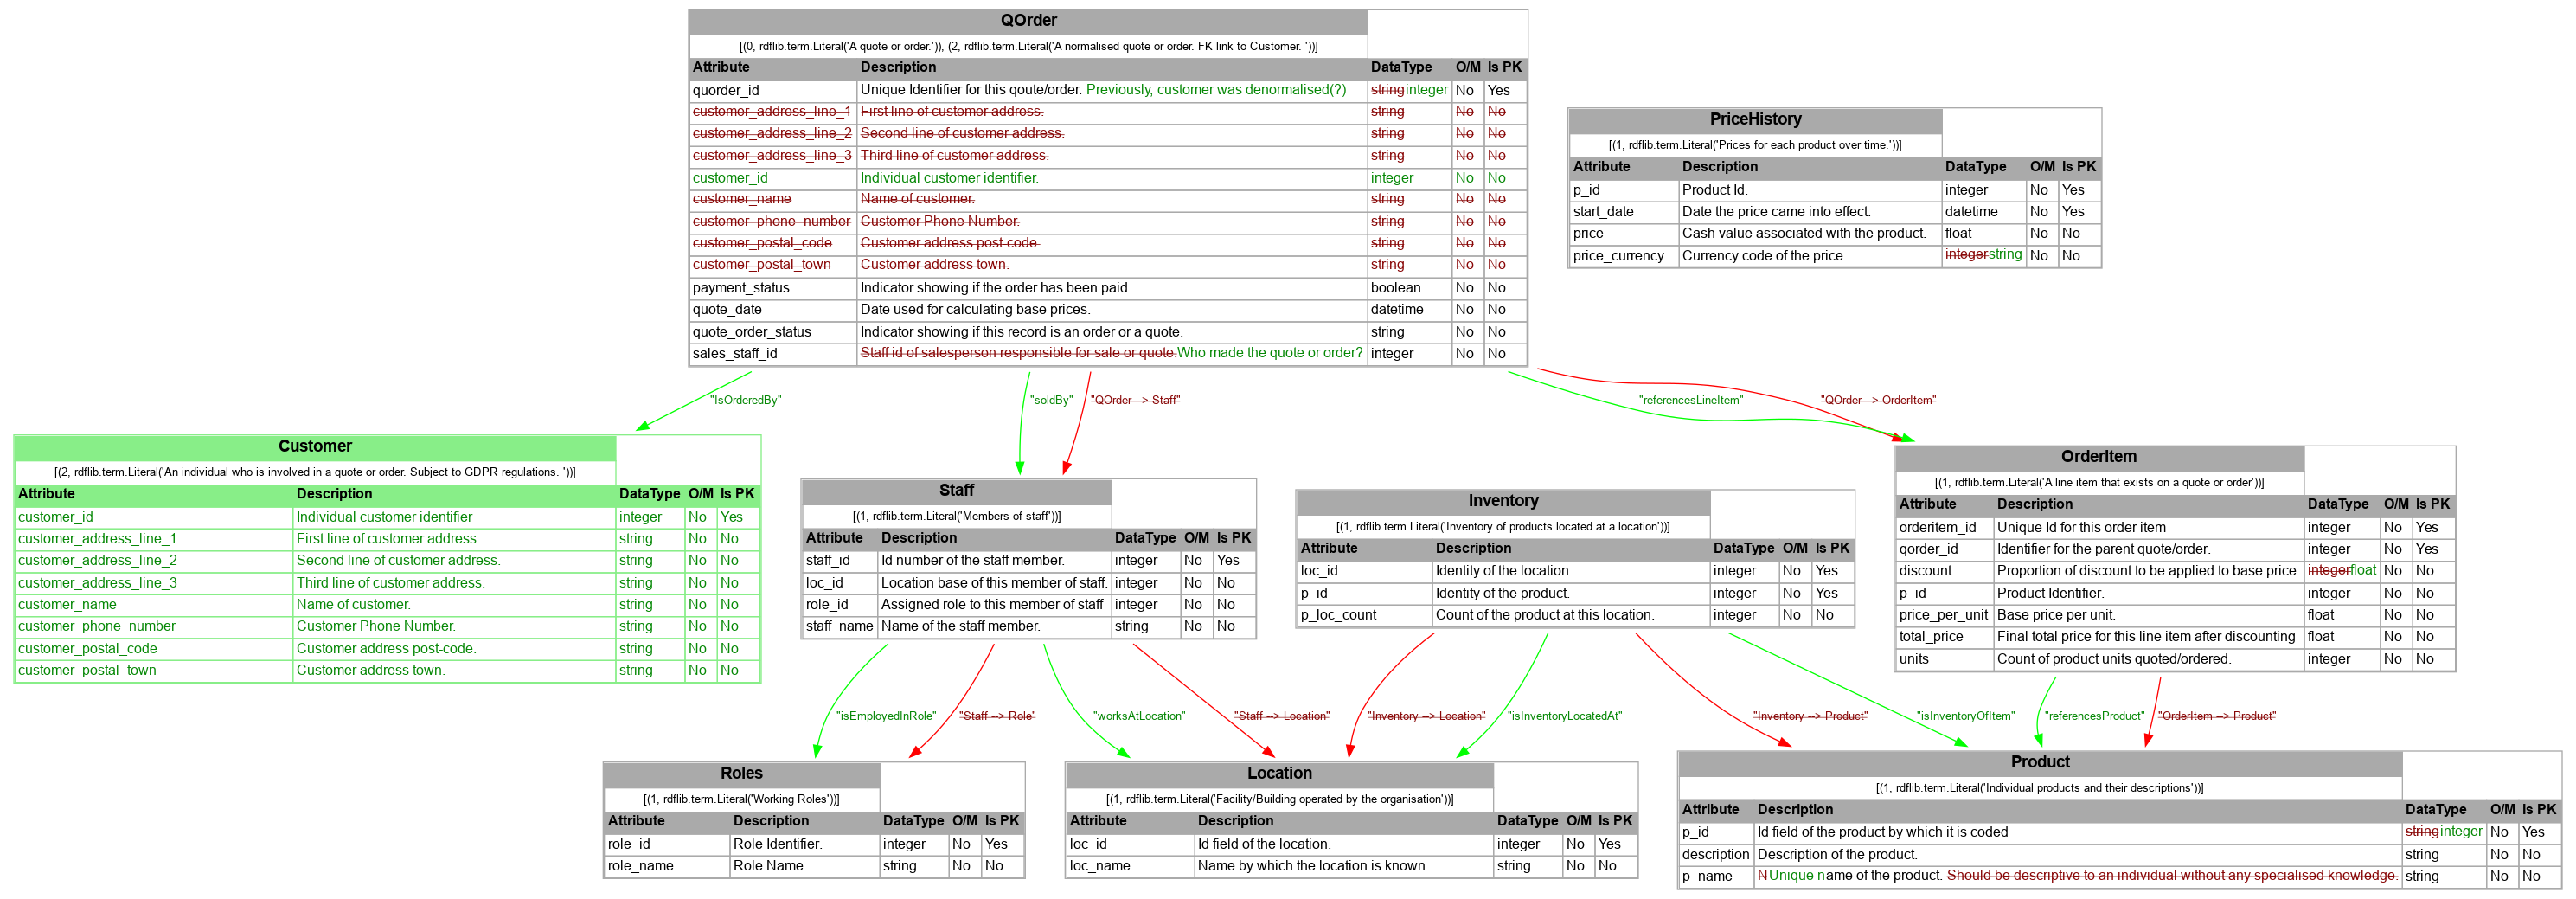

In [45]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s2, option_dict, v_type="png")))

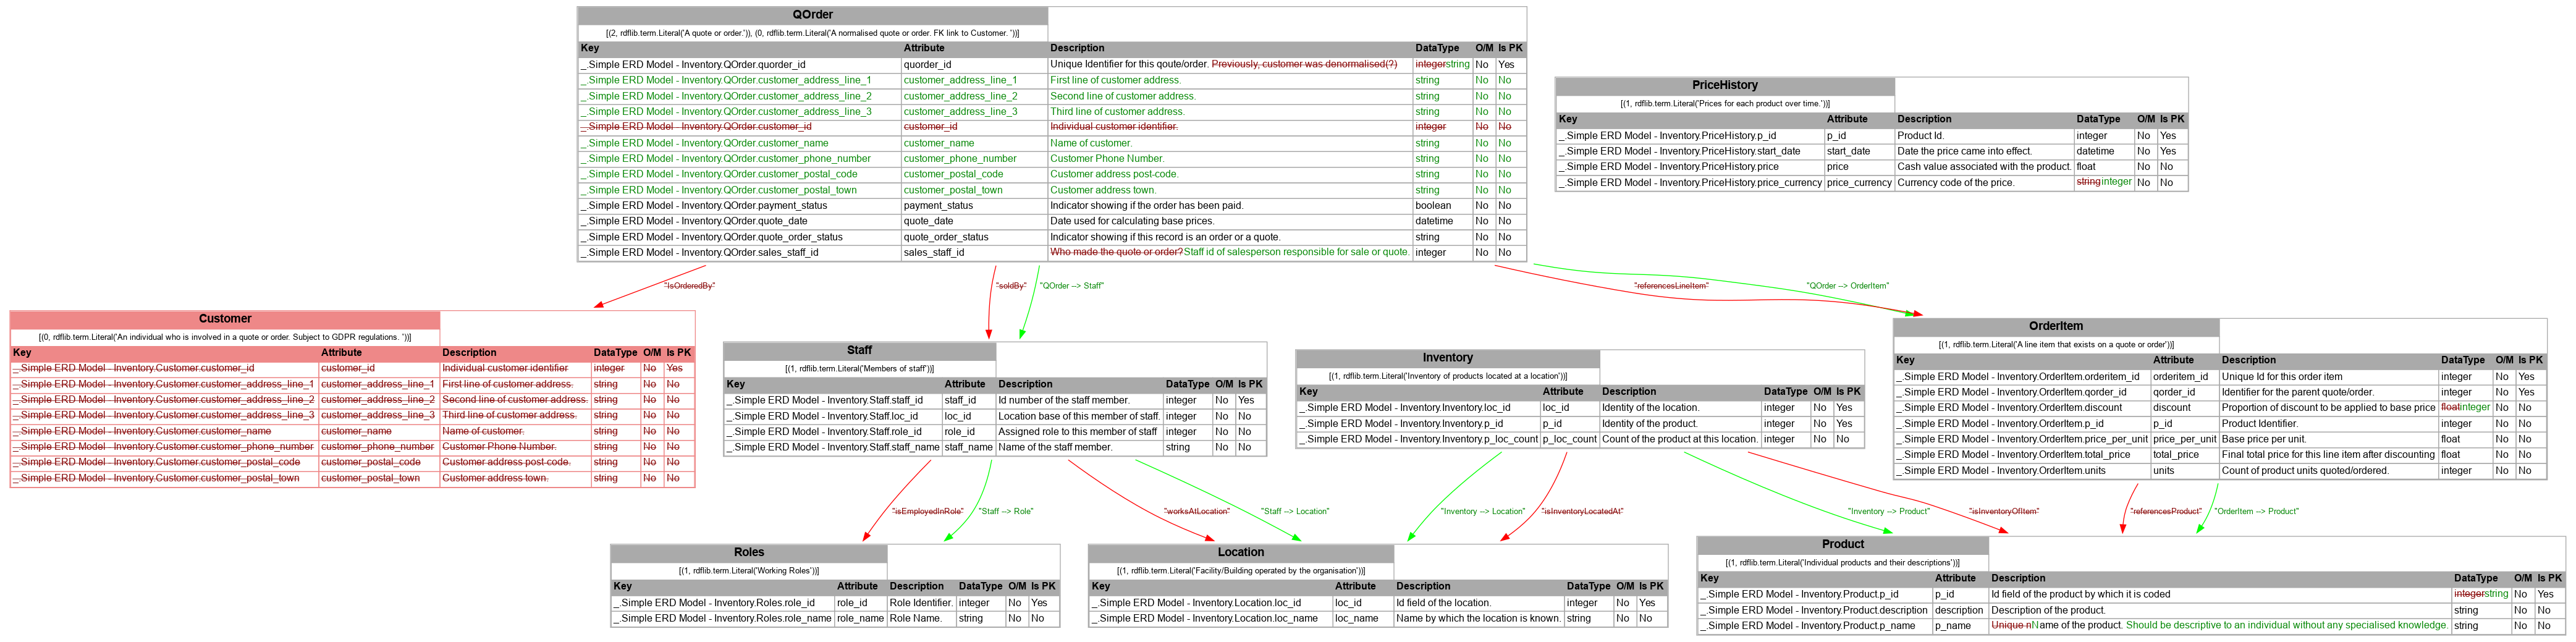

In [42]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s1, option_dict, v_type="png")))

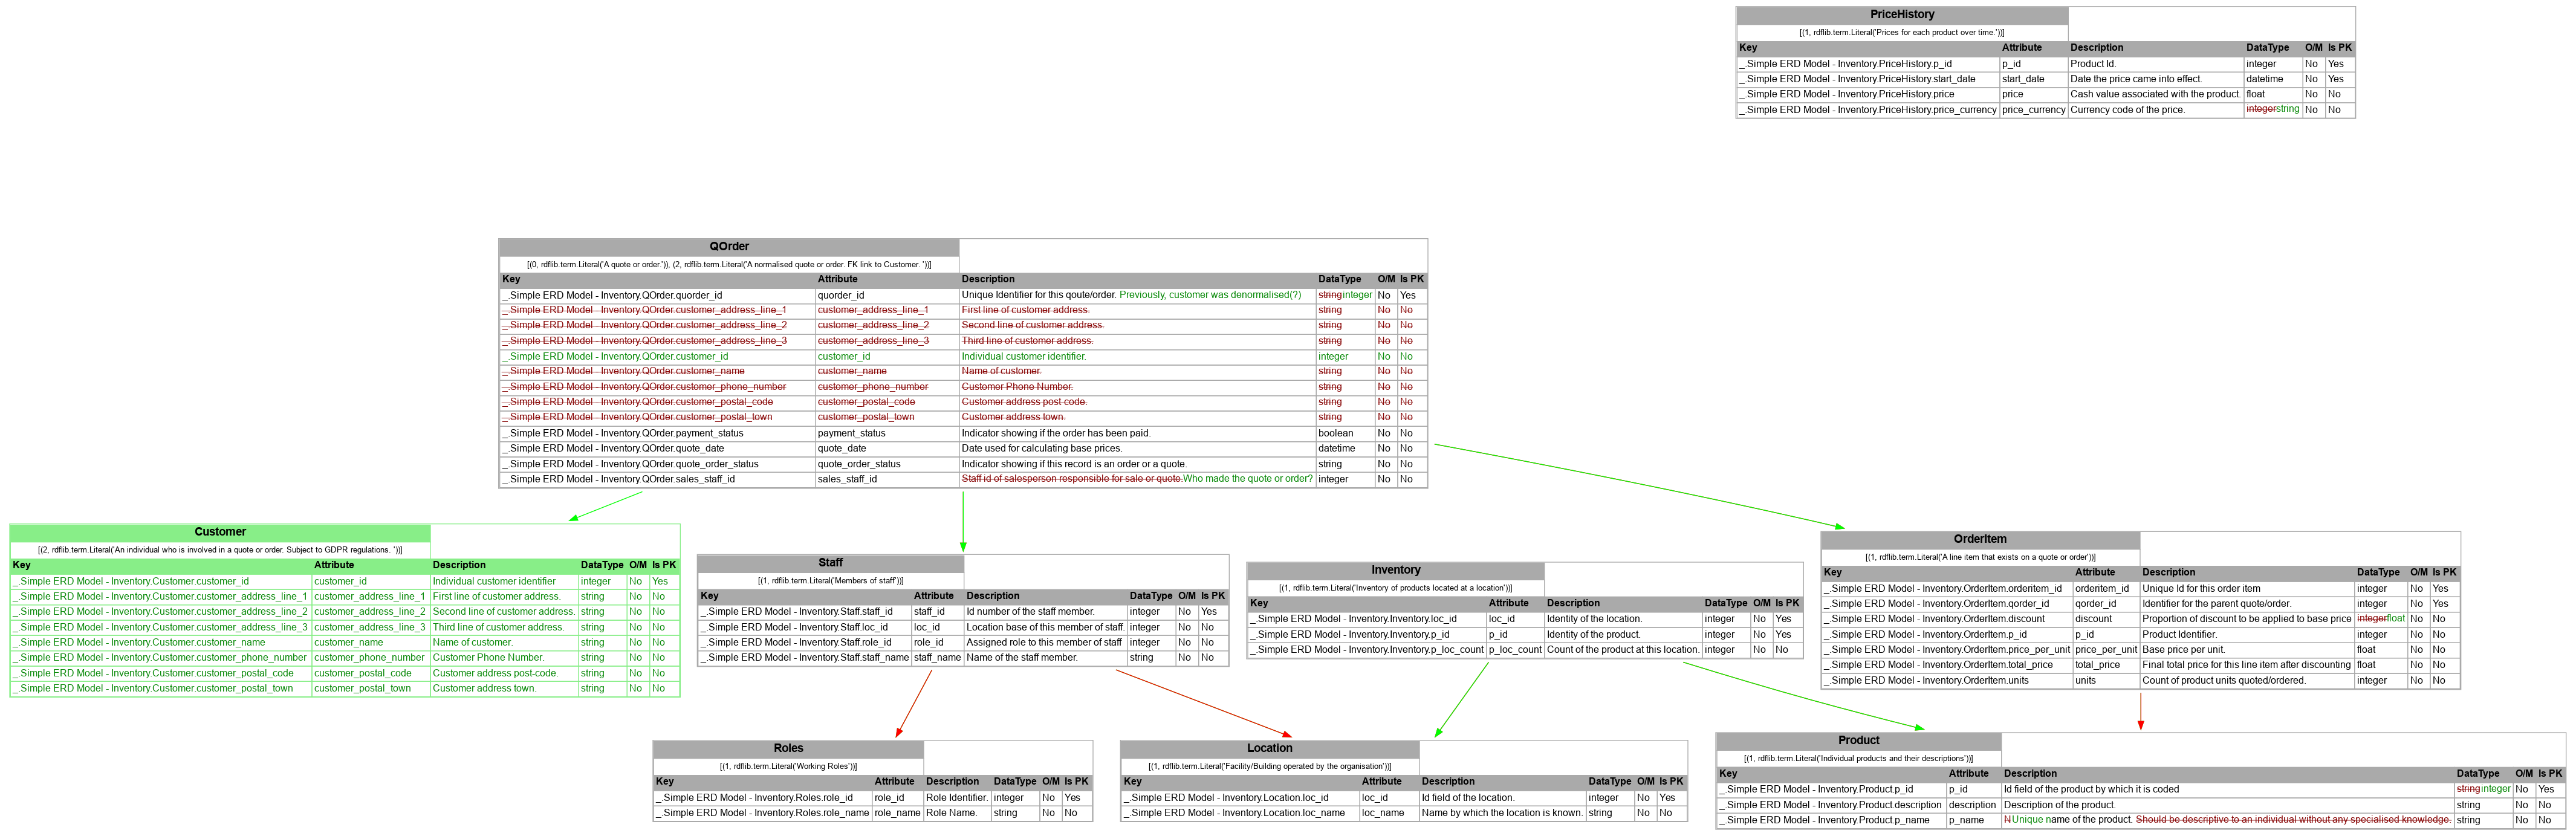

In [43]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s2, option_dict, engine="dot", graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="png")))

In [ ]:
assert False

In [ ]:
mpd = {"created" : "2023-09-26", 
                   "creator" : "tomk", 
                   "description" : "IBM MDM Diagram", 
                   "title" : "IBM MDM Diagram", 
                   "modified" : "2023-09-26"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "IBM MDM Diagram v0.1"
model_data = pd.read_csv(r"../sample/mdm_v11_3_pdm_dmear.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

In [ ]:
qr = repo.run_cached_query("get_discourse_details.sparql")
qr_df = pd.DataFrame(qr)
qr_df

In [ ]:
qi = qr_df.query("description in ['IBM MDM Diagram'] ").index.values
d1 = qr_df.iloc[qi[0]]['discourse']

In [ ]:

qr = repo.run_cached_query("get_discourse_posits_parms_discourse_iris.sparql", parameters=[",".join([URIRef(d1).n3()])], native_rdflib=True)
#results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(qr)
#set(dcontents['p'])
dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()

In [ ]:


s1 = dcd.get(URIRef(d1))

In [ ]:
option_dict = { "u_label" : False, 
                "label" : True, 
                "desc" : True, 
                "optionality" : False, 
                "pk" : False, 
                "datatype" : False }


In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="png")))

In [ ]:
svg_data=DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="svg")

In [ ]:
with open("svg_test.svg", "w") as f:
    f.write(_.decode("utf-8"))

In [ ]:
HTML(_.decode("utf-8"))

In [ ]:

display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="png")))

In [ ]:
assert False

In [ ]:
dot_text = DMEAR_vis.DMEAR_vizdiff_to_dot(s1, s1)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
assert False

In [ ]:
def typed_dictionary_from_triples(triple_set):
    type_d={}
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            if t[2] not in type_d.keys():
                type_d[t[2]]=set([t[0]])
            else:
                type_d[t[2]].add(t[0])
                
    return type_d


def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

def sigmoid(x):
    return 1/(1+(e**(-10*(x-0.5))))

def score_diffset(S1,S2):
    l,i,r = diffset(S1, S2)
    ll,il,rl = len(l), len(i), len(r)
    pos=(0.1*ll)+li+(0.6*lr)
    return sigmoid(pos/(ll+il+rl))
    

def LIR_test(triple, LIR_tuple):
    for e,s in enumerate(LIR_tuple):
        if triple in s:
            return e
    return None
    

def property_per_entity(triple_set, entity):
    property_d={}
    for t in triple_set:
        if t[0] == entity:
            if t[1] not in property_d.keys():
                property_d[t[1]]=set([t[2]])
            else:
                property_d[t[1]].add(t[2])
    return property_d

def retrieve_property_meta(triple_set, LIR_tuple, subject, predicate):
    meta_collection=[]
    for s,p,o in triple_set:
        if s==subject and p==predicate:
            LIR_loc=LIR_test((s,p,o), LIR_tuple)
            meta_collection.append((LIR_loc, o))
    return meta_collection
            
    
    

In [ ]:
def DMEAR_vizdiff_to_dot(S1, S2):
    rdf_type_uri = URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")
    class_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')
    relation_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
    attribute_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')
    L, I, R = diffset(S1, S2)
    obj_dict = typed_dictionary_from_triples(S1.union(S2))
    entities=[]
    ent_node_dir={}
    DMEAR_types = [ URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Model'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class'),
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
                    ]
    for e,entity in enumerate(obj_dict[class_uri]):
        node_name=f"node_{e}"
        ent_node_dir[entity]=node_name
        def_triple = (entity, rdf_type_uri, class_uri)
        LIR_loc = LIR_test(def_triple, (L,I,R))
        eprops = property_per_entity(S1.union(S2), entity)
        unique_ids = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        labels = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        descriptions = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
        content_elements = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains'))
        # possible filter on content_elements having type-assignments of Attribute
        attr_elements = []
        for a_lir, attribute in content_elements:
            aprops = property_per_entity(S1.union(S2), attribute)
            a_labels = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
            a_descs = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
            a_dtypes = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#DataType'))
            a_uniques = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
            a_optionalities = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Optionality'))
            a_pks = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#isIdentifierForClass'))
            attribute_package = {"uri" : attribute, 
                                 "lir" : a_lir, 
                                 "u_label" : a_uniques, 
                                 "label" : a_labels, 
                                 "desc" : a_descs, 
                                 "optionality" : a_optionalities, 
                                 "pk" : a_pks}
            attr_elements.append(attribute_package)
            
        entity_package = {"uri" : entity, 
                          "node" : node_name, 
                          "lir" : LIR_loc, 
                          "u_label" : unique_ids, 
                          "label" : labels, 
                          "desc" : descriptions, 
                          "attributes" : attr_elements}
        
        entities.append(entity_package)
    
    
    relations=[]
    
    for relation in obj_dict[relation_uri]:
        #print(relation)
        rel_triple = (relation, rdf_type_uri, relation_uri)
        rel_lir = LIR_test(rel_triple, (L,I,R))
        rel_props = property_per_entity(S1.union(S2), relation)
        #for k in rel_props.keys():
        #    print (k)
        rel_from_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromClass'))
        rel_to_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToClass'))
        rel_from_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromCardinality'))
        rel_to_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToCardinality'))
        rel_from_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromAttribute'))
        rel_to_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToAttribute'))
        rel_unique = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        rel_label = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        rel_descs = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
        rel_type = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'))
        rel_package = {"uri" : relation, 
                       "lir" : rel_lir, 
                       "u_label" : rel_unique, 
                       "label" : rel_label, 
                       "desc" : rel_descs,
                       "from_class" : rel_from_class, 
                       "to_class" : rel_to_class, 
                       "from_node" : ent_node_dir[rel_from_class[0][1]],
                       "to_node" : ent_node_dir[rel_to_class[0][1]],
                       "from_attribute" : rel_from_attribute, 
                       "to_attribute" : rel_to_attribute, 
                       "from_cardinality" : rel_from_cardinality, 
                       "to_cardinality" : rel_to_cardinality,
                       "rel_type" : rel_type}
        
        relations.append(rel_package)
    
    
    ## Build up entities and relations in dot language

        

    
    #col_dir = { 0 : "'#068806'", 1 : "'#000000'", 2 : "'#880606'"}
    col_dir = { 0 : "RED", 1 : "BLACK", 2 : "GREEN"}
    fg_col_dir = { 0 : "#880606", 1 : "#000000", 2 : "#068806"}
    alt_col_dir = { 0 : "#EE8888", 1 : "#AAAAAA", 2 : "#88EE88"}
    #start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="DejaVu Sans" ] ; \n edge [fontname = "helvetica"]; \n"""
    start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="helvetica" ] ; \n edge [fontname = "helvetica"]; \n"""
     
 
 
    ent_content = ""
    for ents in entities:
        att_content=""
        
        node, col, alt_col, label, uri, desc = ents["node"], col_dir[ents["lir"]], alt_col_dir[ents["lir"]], ents["label"][0][1], ents["uri"], ents["desc"]
                    
        #"<br/>".join(text_utils.ww(html.escape(ents["desc"][0][1]),40))
            
        if len (ents["attributes"])>0:
            # Set header for attribute table
            attrstr = f"""<tr><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Attribute</B></font></td><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Identifier</B></font></td></tr>"""
            att_content=att_content+attrstr
        #print([(x[6][0][1].n3(), x[3][0][1].n3())for x in ents[6]])
        e_sort={"\"Yes\"":0, "\"No\"": 1}
        for att in sorted(ents["attributes"], key=lambda x : (e_sort[x["pk"][0][1].n3()], x["u_label"][0][1].n3())):
            attr=att["label"][0][1]
            pk=att["pk"][0][1]
            attr_lir = att["lir"]
            
            attr_col=fg_col_dir[attr_lir]
            #print(attr_col)
            if attr_lir != 0:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'>{attr}</font></td><td align='left'><font point-size='12' color='{attr_col}'>{pk}</font></td></tr>"""
            else:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'><s>{attr}</s></font></td><td align='left'><font point-size='12' color='{attr_col}'><s>{pk}</s></font></td></tr>"""
            att_content=att_content+attrstr
        
        #print(label, col)

        entstr = f"""{node} [ shape=none, color={col} label=< <table color='{alt_col}'
         cellborder='1' cellspacing='0' border='1'><tr>
        <td colspan='2' bgcolor='{alt_col}'><B>{label}</B></td></tr><tr>
        <td href='{uri}' bgcolor='#ffffff' colspan='2' ALIGN='center'>
        <font point-size='10' color='#000000'>{desc}</font>
        </td>
        </tr>{att_content}</table> > ] \n"""

        ent_content = ent_content + entstr
            
    
    relstr = ""

    
    for rels in relations:
        fromnode, tonode, rel_col, rel_label = rels["from_node"], rels["to_node"], col_dir[rels["lir"]], rels["label"][0][1].n3()
        fg_rel_col = fg_col_dir[rels["lir"]]
        if rels["lir"]!=0:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'>{rel_label}</font> > ] ;\n"""
        else:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'><s>{rel_label}</s></font> > ] ;\n"""
        
    return start  + relstr + ent_content + "}"

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s1, s1)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s1, s2)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s1)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
timestamp = datetime.now()

elapsed = timestamp - start
print(elapsed)

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
node = dg.get_nodes()[0]

In [ ]:
node.get_pos()

In [ ]:
dg.create_dot()

In [ ]:
node = dg.get_nodes()[0]

In [ ]:
import difflib

In [ ]:
a = "Mary had a little lamb. Its fleece as white as snow."
b = "Sue had a little puppy. Its eyes as dark as night."

In [ ]:
diffs = difflib.SequenceMatcher(None, a,b)

In [ ]:
diffs.a

In [ ]:
diffs.b

In [ ]:
from IPython.display import display
from IPython.display import HTML

In [ ]:
output=""
for c, i1, i2, j1, j2 in diffs.get_opcodes():
    if c in ["replace", "delete"]:
        print(c, b[j1:j2])
        output=output+"<font color=\"red\"><s>"+a[i1:i2]+"</s></font>"+"<font color=\"green\">" + b[j1:j2]+"</font>"
    elif c in "insert":
        print(c, b[j1:j2])
        output=output+"<font color=\"green\">" + b[j1:j2]+"</font>"
    else:
        print(c, b[j1:j2])
        output=output+b[j1:j2]
        
display(HTML(output))
        

In [ ]:
from IPython.display import display
from IPython.display import HTML

In [ ]:
a = "This text starts the same. And ends the same way."
b = "This text starts the same, but includes a section that deviates from the original before ending the same way."

In [ ]:
def markup_text_diffs(text_a, text_b):

    diffs = difflib.SequenceMatcher(None, text_a,text_b)

    output=""
    for c, i1, i2, j1, j2 in diffs.get_opcodes():
        if c in ["replace", "delete"]:
            #print(c, b[j1:j2])
            output=output+"<font color=\"red\"><s>"+text_a[i1:i2]+"</s></font>"+"<font color=\"green\">" + text_b[j1:j2]+"</font>"
        elif c in "insert":
            #print(c, b[j1:j2])
            output=output+"<font color=\"green\">" + text_b[j1:j2]+"</font>"
        else:
            #print(c, b[j1:j2])
            output=output+text_b[j1:j2]
    return output

        

In [ ]:
a = "Mary yearned for a little lamb its fleece as white as snow."
b = "Many years ago, a little bird lived in a tree. What did it know."
output = markup_text_diffs(a, b)
display(HTML(output))

In [ ]:
diffs.get_opcodes()

In [ ]:
output

In [ ]:
a = "Mary yearned for a little lamb its fleece as white as snow."
b = "Many years ago, a little bird lived in a tree. What did it know."
output = markup_text_diffs(b, b)
display(HTML(output))

In [ ]:
HTML(DMEAR_vis.markup_text_diffs(a,b,{ 0 : "#880606", 1 : "#000000", 2 : "#068806", 3 : "#BB3333"}))